# Playground

In [1]:
import pandas as pd
import numpy as np
import csv
import keras

from keras.utils import np_utils

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

image_width = 480
image_height = 480
image_depth = 1

num_classes = 3
categories_name = ['Background', 'Cosmic', 'Beam']
categories_value = [0, 1, 2]

# Total: 10620
n_training = 30
training_feature_file = "input_files/training/feature_w.csv"
training_label_file = "input_files/training/label_w.csv"

# Total: 1320
n_validation = 10
validation_feature_file = "input_files/validation/feature_w.csv"
validation_label_file = "input_files/validation/label_w.csv"

# Total: 1330
n_testing = 10
testing_feature_file = "input_files/testing/feature_w.csv"
testing_label_file = "input_files/testing/label_w.csv"

print(keras.__version__)

Using TensorFlow backend.


2.2.4


In [2]:
def get_data(feature_file, label_file):
    with open(feature_file, "r") as csv1, open(label_file, "r") as csv2:
        reader1 = csv.reader(csv1)
        reader2 = csv.reader(csv2)
        # Skip the header row
        next(reader1)
        next(reader2)
        for row1, row2 in zip(reader1, reader2):
            array_row1 = np.array(row1, dtype=np.float)
            array_row2 = np.array(row2, dtype=np.int)
            yield array_row1, array_row2

def preprocess_x(x):
    """
    Feature is the adc values; scale it such that each value is between 0 and 1
    """
    x_max = np.max(x)
    x = x/x_max
    return x.reshape(1, image_width, image_height, image_depth)

def preprocess_y(y):
    return np_utils.to_categorical(y, num_classes=num_classes).reshape(1, image_width, image_height, num_classes)

class DataGenerator(keras.utils.Sequence):
    """
    Sequence are a safer way to do multiprocessing. 
    This structure guarantees that the network will only train once on each sample per epoch 
    which is not the case with generators.
    """
    def __init__(self, feature_file, label_file, max_index=1, batch_size=1):
        self.feature_file = feature_file
        self.label_file = label_file
        self.max_index = max_index
        self.batch_size = batch_size
        self.on_epoch_end()
        
    def __len__(self):
        """
        The number of batches in a epoch.
        """
        return int(np.ceil(self.max_index / float(self.batch_size)))
        
    def __getitem__(self, index):
        """
        Generate one batch of data at 'index', which is the position of the batch in the Sequence.
        """
        if index + self.batch_size >= self.max_index:
            self.rows = np.arange(0, min(self.batch_size, self.max_index))
        else:
            self.rows = np.arange(index, min(index + self.batch_size, self.max_index))
        
        # Generate data
        X, y = self.__data_generation(self.rows)
                
        return X, y

    def on_epoch_end(self):
        """
        Update after each epoch.
        """
        self.rows = np.arange(0, min(self.batch_size, self.max_index))
        
        self.reader1 = csv.reader(open(self.feature_file, "r"))
        self.reader2 = csv.reader(open(self.label_file, "r"))

        # Skip the header row and count coln
        self.n_col = len(next(self.reader1))
        next(self.reader2)   

    def __data_generation(self, rows):
        """Generates data containing batch_size samples"""
        samples = np.zeros((len(rows), image_width, image_height, image_depth))
        targets = np.zeros((len(rows), image_width, image_height, num_classes))
        for j, row in enumerate(rows):
            for row1, row2 in zip(self.reader1, self.reader2):
                array_row1 = np.array(row1, dtype=np.float)
                samples[j,:,:,:] = preprocess_x(array_row1)
                next(self.reader1)

                array_row2 = np.array(row2, dtype=np.int)
                targets[j,:,:,:] = preprocess_y(array_row2)
                next(self.reader2)
                    
        return samples, targets

In [4]:
from collections import Counter

def get_class_weights(y):
    """
    Returns the weights for each class based on the frequencies of the samples
    For 3 classes with classA:10%, classB:50% and classC:40%, the weights will be:
    {0:5, 1:1, 2:1.25}
    This means that if you miss-classify classA the loss will be 5x more than miss-classifying classB and so on...
    """
    counter = Counter(y)

    majority = max(counter.values())
    return {cls: float(majority) / count for cls, count in counter.items()}

In [5]:
iter_data = get_data(training_feature_file, training_label_file)
for i in range(10):
    X, y = next(iter_data)
    coefficients = get_class_weights(y)
    coefficients = [key for index, key in coefficients.items()]
    print(coefficients)

[1.0, 31.063083136053475, 1439.1225806451612]
[1.0, 36.31869918699187, 250.96629213483146]
[1.0, 22.294696278267924, 318.15918958031835]
[1.0, 24.522211144344745, 20123.81818181818]
[1.0, 19.244894366197183, 523.0191387559809]
[1.0, 21.221369596891694, 133.95095033721643]
[1.0, 19.442551293487956, 175.90879741727198]
[1.0, 21.854148037754594, 589.710455764075]
[1.0, 31.913689625607315, 3190.457142857143]
[1.0, 21.28601838413159, 2972.8513513513512]


In [ ]:
coefficients = [1.0, 30.0, 300.0]

In [6]:
def plot_feature(feature_image):
    fig, ax0 = plt.subplots(1, 1, figsize=(10,5), facecolor='w')
    c0 = ax0.imshow(feature_image, cmap='ocean_r',interpolation='none', origin='lower',
                    vmin=0.0, vmax=1.0)
    fig.colorbar(c0, ax=ax0)
    ax0.set_xlabel("Global wire no.", fontsize=15, fontname='Georgia',fontweight='bold')
    ax0.set_ylabel("TDC", fontsize=1, fontname='Georgia',fontweight='bold')
    ax0.set_title('Feature', fontsize=20,fontname='Georgia',fontweight='bold')

    plt.show()

def plot_label(label_image):
    fig, ax0 = plt.subplots(1, 1, figsize=(10,5), facecolor='w')
    c0 = ax0.imshow(feature_image, cmap='gist_heat_r',interpolation='none', origin='lower',
                    vmin=0.0, vmax=1.0)
    fig.colorbar(c0, ax=ax0)
    ax0.set_xlabel("Global wire no.", fontsize=15, fontname='Georgia',fontweight='bold')
    ax0.set_ylabel("TDC", fontsize=1, fontname='Georgia',fontweight='bold')
    ax0.set_title('Label', fontsize=20,fontname='Georgia',fontweight='bold')

    plt.show()

In [3]:
my_gen = DataGenerator(training_feature_file, training_label_file)
X, y = my_gen.__getitem__(0)

(230400,)
(480, 480)


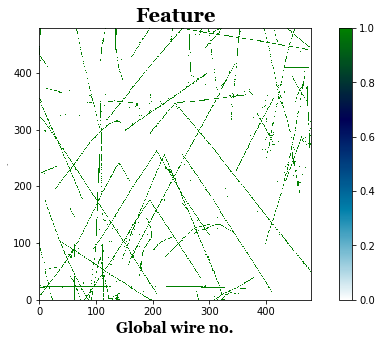

In [7]:
print(X.shape)
feature_image = X[0].reshape(image_width, image_height)
print(feature_image.shape)
plot_feature(feature_image)

In [8]:
print(y.shape)
image_label = np.argmax(y[0], axis=2)
print(label_image.shape)
plot_label(label_image)

(230400,)


AxisError: axis 2 is out of bounds for array of dimension 1

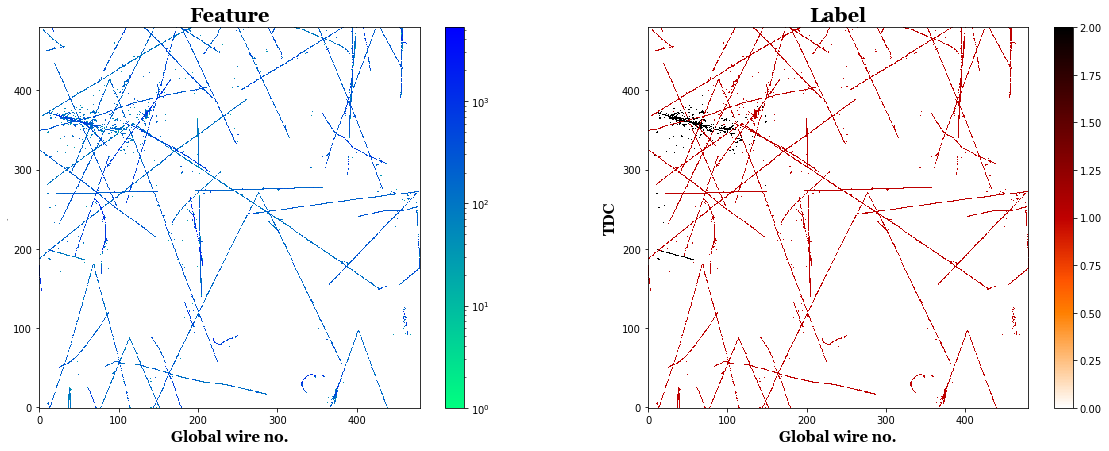

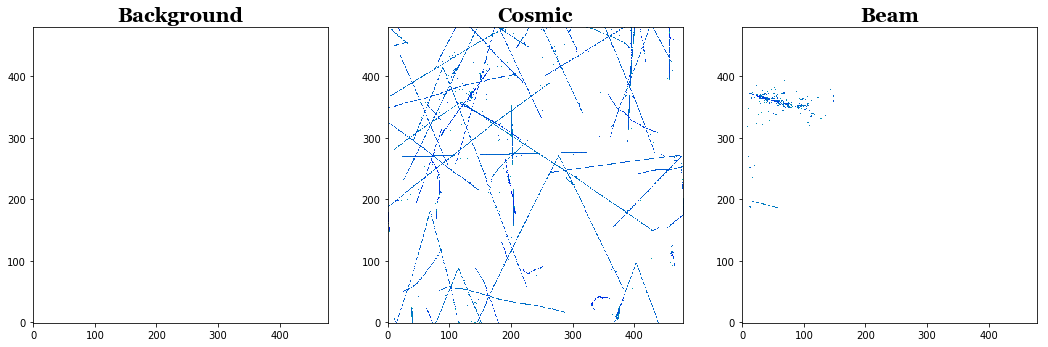

In [9]:
def plot_feature_label(feature_image, label_image, plot_name):
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(20,7), facecolor='w')
    c0 = ax0.imshow(feature_image, cmap='winter_r',interpolation='none', origin='lower', 
                    norm=LogNorm(vmin=1.0, vmax=abs(feature_image).max()))
    fig.colorbar(c0, ax=ax0)
    ax0.set_xlabel("Global wire no.", fontsize=15, fontname='Georgia',fontweight='bold')
    ax0.set_ylabel("TDC", fontsize=1, fontname='Georgia',fontweight='bold')
    ax0.set_title('Feature', fontsize=20,fontname='Georgia',fontweight='bold')

    c1= ax1.imshow(label_image,cmap='gist_heat_r',interpolation='none', origin='lower', 
                   vmin=abs(label_image).min(), vmax=abs(label_image).max())
    fig.colorbar(c1, ax=ax1)
    ax1.set_xlabel("Global wire no.", fontsize=15, fontname='Georgia',fontweight='bold')
    ax1.set_ylabel("TDC", fontsize=15, fontname='Georgia',fontweight='bold')
    ax1.set_title('Label', fontsize=20, fontname='Georgia',fontweight='bold')

    plt.show()
    fig.savefig(plot_name, bbox_inches='tight')

def plot_categories(feature_image, label_image, plot_name):
    fig, axes = plt.subplots(1, len(categories_value), figsize=(18,12), facecolor='w')
    for index, value in enumerate(categories_value):
        ax = axes[index]
        mask = (label_image == value)
        ax.imshow(feature_image*mask, cmap='winter_r',interpolation='none', origin='lower', 
                  norm=LogNorm(vmin=1.0, vmax=abs(feature_image).max()))
        ax.set_title(categories_name[index], fontsize=20, fontname='Georgia',fontweight='bold')
    plt.show()
    fig.savefig(plot_name, bbox_inches='tight')

iter_data = get_data(training_feature_file, training_label_file)
next(iter_data)
next(iter_data)
X, y = next(iter_data)

feature_image = X.reshape(image_width, image_height)
label_image = y.reshape(image_width, image_height)
plot_feature_label(feature_image, label_image, 'plots/W-PlaneFeatureAndLabel.pdf')
plot_categories(feature_image, label_image, 'plots/W-planeBkgCosmicBeam.pdf')

# Build U-net model

In [10]:
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.activations import softmax

def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # First layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    # Second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True):
    # Vontracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # Expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(num_classes, (1, 1), activation='softmax') (c9)        
    
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [12]:
import tensorflow as tf
from keras import backend as K

def weighted_loss(num_classes, coefficients):
    """
    Implements weighted categorical cross entropy objective function.
    Use this loss function with median frequency coefficients weights for class balance.
    """
    
    coefficients = tf.constant(coefficients)
    num_classes = tf.constant(num_classes)

    def loss(labels, logits):
        with tf.name_scope('loss_1'):
            logits = tf.reshape(logits, (-1, num_classes))
            epsilon = tf.constant(value=1e-10)

            logits = logits + epsilon
            # consturct one-hot label array
            labels = tf.to_float(tf.reshape(labels, (-1, num_classes)))
            softmax = tf.nn.softmax(logits)
            
            cross_entropy = -tf.reduce_sum(tf.multiply(labels * tf.log(softmax + epsilon), 
                                                       coefficients), reduction_indices=[1])
            cross_entropy_mean = tf.reduce_mean(cross_entropy, name='cross_entropy')

            tf.add_to_collection('losses', cross_entropy_mean)
            loss = tf.add_n(tf.get_collection('losses'), name='total_loss')
            #loss = cross_entropy_mean
        return loss
    return loss

def mean_iou(y_true, y_pred):
    """
    Calculate per-step mean Intersection-Over-Union (mIOU).
    Computes the IOU for each semantic class and then computes the average over classes.
    """
    score, up_opt = tf.metrics.mean_iou(y_true, y_pred, num_classes)
    K.get_session().run(tf.local_variables_initializer())
    with tf.control_dependencies([up_opt]):
        score = tf.identity(score)
    return score

In [13]:
input_img = Input((image_height, image_width, image_depth))
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)

model.compile(optimizer = 'adam', 
              loss=weighted_loss(num_classes, coefficients),
              metrics = [mean_iou])
#model.summary()

In [14]:
batch_size = 10

# Stop training when a monitored quantity has stopped improving after 20 epochs
early_stop = EarlyStopping(patience=20, verbose=1)

# Reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(factor=0.3, patience=3, cooldown=3, verbose=1)

# Save the best model after every epoch
check_point = ModelCheckpoint(filepath='saved_models/model_and_weights.hdf5', 
                              save_best_only=True, verbose=1)

train_gen = DataGenerator(feature_file=training_feature_file, 
                           label_file=training_label_file,  
                           max_index=n_training, 
                           batch_size=batch_size)

val_gen = DataGenerator(feature_file=validation_feature_file, 
                         label_file=validation_label_file, 
                         max_index=n_validation, 
                         batch_size=batch_size)
    
test_gen = DataGenerator(feature_file=testing_feature_file, 
                          label_file=testing_label_file, 
                          max_index=n_testing, 
                          batch_size=batch_size)

In [15]:
epochs = 10

history = model.fit_generator(train_gen, 
                              steps_per_epoch = n_training//batch_size,
                              epochs=epochs,
                              validation_data=val_gen,
                              validation_steps= n_validation//batch_size,
                              verbose=1,
                              callbacks=[check_point, early_stop, reduce_lr])

Epoch 1/2
 - 582s - loss: 0.1248 - acc: 0.2966 - val_loss: 0.2584 - val_acc: 0.4133

Epoch 00001: val_loss improved from inf to 0.25841, saving model to saved_models/model_and_weights.hdf5
Epoch 2/2
 - 502s - loss: 0.1132 - acc: 0.4383 - val_loss: 0.2437 - val_acc: 0.2440

Epoch 00002: val_loss improved from 0.25841 to 0.24369, saving model to saved_models/model_and_weights.hdf5


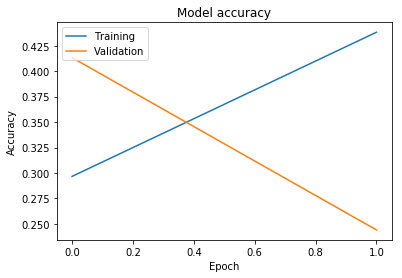

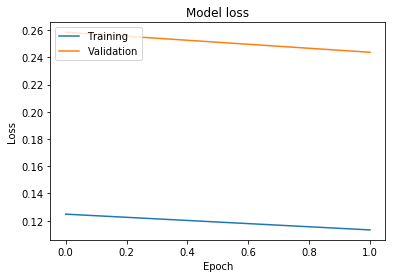

In [16]:
# Summarize history for IoU
plt.plot(history.history['mean_iou'])
plt.plot(history.history['val_mean_iou'])
plt.title('Mean IoU')
plt.ylabel('Mean IoU')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.savefig('plots/model_accuracy.pdf', bbox_inches='tight')
plt.show()

# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Weighted loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.savefig('plots/model_loss.pdf', bbox_inches='tight')
plt.show()

In [17]:
# Load the model with the best classification accuracy on the validation set
model.load_weights('saved_models/model_and_weights.hdf5')

In [ ]:
#test_gen_pred = model.predict_generator(test_gen)
#print(test_gen_pred.shape)

In [18]:
iter_data = iter(get_data(testing_feature_file, testing_label_file))
X, y = next(iter_data)
print(X.shape)
print(y.shape)
X_procesed = preprocess_x(X)
print(X_procesed.shape)
predictions = model.predict_on_batch(X_procesed)
print(predictions.shape)

y_reshaped = preprocess_y(y)
print(y_reshaped.shape)

(230400,)
(230400,)
(1, 480, 480, 1)
(1, 480, 480, 3)
(1, 480, 480, 3)


In [19]:
prediction_max = np.argmax(predictions, axis=3)
print(prediction_max.shape)

(1, 480, 480)


In [27]:
def intersection_over_union(y_true, y_pred, epsilon=1e-6):
    
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true + y_pred)

    return ((2. * intersection + epsilon)/(union + epsilon))

def average_intersection_over_union(y_true, y_pred, n_classes=num_classes):
    """
    Average over classes and batch
    """
    n_preds = predictions.shape[0]
    print('Number of validation samples IoU evaulated on: {}'.format(n_preds))
    
    total_iou = 0
    for c in range(n_classes):
        average_over_batch_iou = intersection_over_union(y_true[:,:,:,c], y_pred[:,:,:,c])/n_preds
        print('Average IoU for {} is: {:.3f}'.format(categories_name[c], average_over_batch_iou))
        total_iou += average_over_batch_iou
        
    print('Global average IoU is: {:.3f}'.format(total_iou/n_classes))

average_intersection_over_union(y_reshaped, predictions)

Number of validation samples IoU evaulated on: 1
Average IoU for Background is: 0.703
Average IoU for Cosmic is: 0.122
Average IoU for Beam is: 0.004
Global average IoU is: 0.276


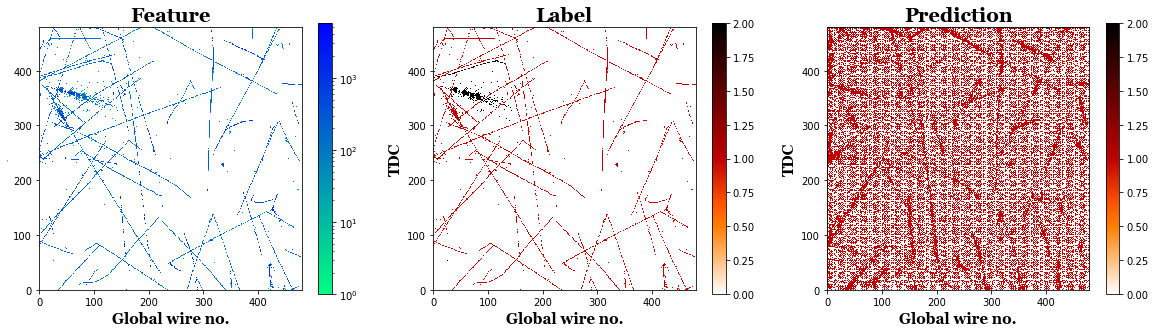

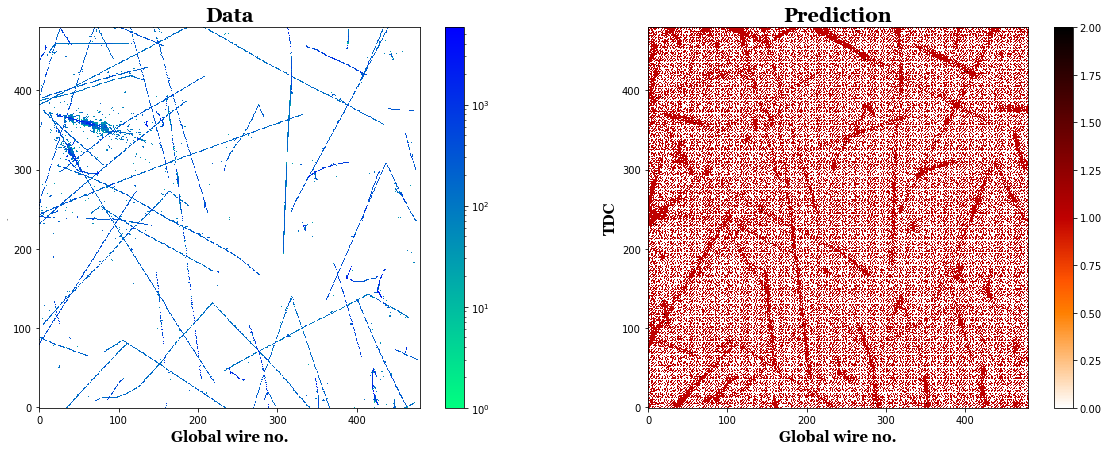

In [21]:
def plot_feature_label_prediction(feature_image, label_image, prediction_image, plot_name):
    fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(20,5), facecolor='w')
    c0 = ax0.imshow(feature_image, cmap='winter_r',interpolation='none', origin='lower', 
                    norm=LogNorm(vmin=1.0, vmax=abs(feature_image).max()))
    fig.colorbar(c0, ax=ax0)
    ax0.set_xlabel("Global wire no.", fontsize=15, fontname='Georgia',fontweight='bold')
    ax0.set_ylabel("TDC", fontsize=1, fontname='Georgia',fontweight='bold')
    ax0.set_title('Feature', fontsize=20,fontname='Georgia',fontweight='bold')

    c1= ax1.imshow(label_image,cmap='gist_heat_r',interpolation='none', origin='lower', 
                   vmin=abs(label_image).min(), vmax=abs(label_image).max())
    fig.colorbar(c1, ax=ax1)
    ax1.set_xlabel("Global wire no.", fontsize=15, fontname='Georgia',fontweight='bold')
    ax1.set_ylabel("TDC", fontsize=15, fontname='Georgia',fontweight='bold')
    ax1.set_title('Label', fontsize=20, fontname='Georgia',fontweight='bold')

    c2= ax2.imshow(prediction_image, cmap='gist_heat_r',interpolation='none', origin='lower', 
                   vmin=abs(prediction_image).min(), vmax=abs(prediction_image).max())
    fig.colorbar(c2, ax=ax2)
    ax2.set_xlabel("Global wire no.", fontsize=15, fontname='Georgia',fontweight='bold')
    ax2.set_ylabel("TDC", fontsize=15, fontname='Georgia',fontweight='bold')
    ax2.set_title('Prediction', fontsize=20, fontname='Georgia',fontweight='bold')

    plt.show()
    fig.savefig(plot_name, bbox_inches='tight')

def plot_data_prediction(data_image, prediction_image, plot_name):
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(20,7), facecolor='w')
    c0 = ax0.imshow(data_image, cmap='winter_r',interpolation='none', origin='lower', 
                    norm=LogNorm(vmin=1.0, vmax=abs(data_image).max()))
    fig.colorbar(c0, ax=ax0)
    ax0.set_xlabel("Global wire no.", fontsize=15, fontname='Georgia',fontweight='bold')
    ax0.set_ylabel("TDC", fontsize=1, fontname='Georgia',fontweight='bold')
    ax0.set_title('Data', fontsize=20,fontname='Georgia',fontweight='bold')

    c1= ax1.imshow(prediction_image, cmap='gist_heat_r',interpolation='none', origin='lower', 
                   vmin=abs(prediction_image).min(), vmax=abs(prediction_image).max())
    fig.colorbar(c1, ax=ax1)
    ax1.set_xlabel("Global wire no.", fontsize=15, fontname='Georgia',fontweight='bold')
    ax1.set_ylabel("TDC", fontsize=15, fontname='Georgia',fontweight='bold')
    ax1.set_title('Prediction', fontsize=20, fontname='Georgia',fontweight='bold')

    plt.show()
    fig.savefig(plot_name, bbox_inches='tight')

feature_image = X.reshape(image_width, image_height)
label_image = y.reshape(image_width, image_height)
prediction_image = prediction_max.reshape(image_width, image_height)
plot_feature_label_prediction(feature_image, label_image, prediction_image, 'plots/feature_label_prediction.pdf')

plot_data_prediction(feature_image, prediction_image, 'plots/data_prediction.pdf')